In [ ]:
import os
import sys

# Set paths
sys.path.extend([
    os.path.abspath(os.path.join("../..")),
    os.path.abspath(os.path.join("../../../BayesFlow_dev/BayesFlow/"))
])


import datetime
from functools import partial

import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

from network import configure_input
from helpers import custom_plot_sbc_ecdf
from simulation import model_prior, alpha_gen_fixed, stationary_SIR

In [2]:
from matplotlib import rcParams

In [3]:
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator, ContextGenerator
from bayesflow.trainers import Trainer
from bayesflow.summary_networks import SequenceNetwork

In [4]:
RNG = np.random.default_rng(2023)

In [5]:
FIX_ALPHA = 1.0

In [6]:
prior_context = ContextGenerator(batchable_context_fun=partial(alpha_gen_fixed, fix_alpha=FIX_ALPHA))
prior = Prior(prior_fun=model_prior, context_generator=prior_context)

In [7]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=1000000)

### Loading Real Data

We will define a simple helper function to load the actually reported cases for the first 2 weeks in Germany.

In [8]:
def load_data():
    """Helper function to load cumulative cases and transform them to new cases."""

    confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    confirmed_cases = pd.read_csv(confirmed_cases_url, sep=",")

    date_data_begin = datetime.date(2020, 3, 1)
    date_data_end = datetime.date(2020, 3, 15)
    format_date = lambda date_py: f"{date_py.month}/{date_py.day}/{str(date_py.year)[2:4]}"
    date_formatted_begin = format_date(date_data_begin)
    date_formatted_end = format_date(date_data_end)

    cases_obs = np.array(
        confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", date_formatted_begin:date_formatted_end]
    )[0]
    new_cases_obs = np.diff(cases_obs)
    return new_cases_obs

Again, we can collect the simulator settings, together with the observed data, into a dictionary:

In [9]:
config = {"T": 14, "N": 83e6, "obs_data": load_data()}

And we now define our simulator as before, using fixed $T$ and $N$. You already guessed this, that varying this variables will amount to nothing different than further context variables...

In [10]:
simulator = Simulator(simulator_fun=partial(stationary_SIR, T=config["T"], N=config["N"]))

### Generative Model

In [11]:
model = GenerativeModel(prior, simulator, name="covid_simulator")

INFO:root:Performing 2 pilot runs with the covid_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 14, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:Could not determine shape of prior batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


## Defining the Amortizer and Trainer

We can always do a quick check that our configurator works well with the outputs of the generative model:

In [12]:
_ = configure_input(model(batch_size=2), prior_means, prior_stds, is_fix_alpha=True)

In [13]:
from network import setup_network

CHECKPOINT_PATH = "checkpoints/single_nets/unscaled"

amortizer, trainer = setup_network(
    generative_model=model, 
    checkpoint_path=CHECKPOINT_PATH,
    prior_means=prior_means,
    prior_stds=prior_stds,
    is_fix_alpha=True
)

INFO:root:Loaded loss history from checkpoints/single_nets/unscaled\history_75.pkl.
INFO:root:Networks loaded from checkpoints/single_nets/unscaled\ckpt-75


## Data

In [14]:
offline_data = model(2**14)
val_data = model(500)

## Training Phase

In [15]:
if not os.path.exists(CHECKPOINT_PATH): # Only train when no checkpoints exist    
    with tf.device('/cpu:0'):  # Faster for these small networks
        h = trainer.train_offline(offline_data, epochs=75, batch_size=32, validation_sims=val_data)

## Validation

In [16]:
param_names = [r"$\lambda$", r"$\mu$", r"$D$", r"$I_0$", r"$\psi$"]
h = trainer.loss_history.get_plottable()

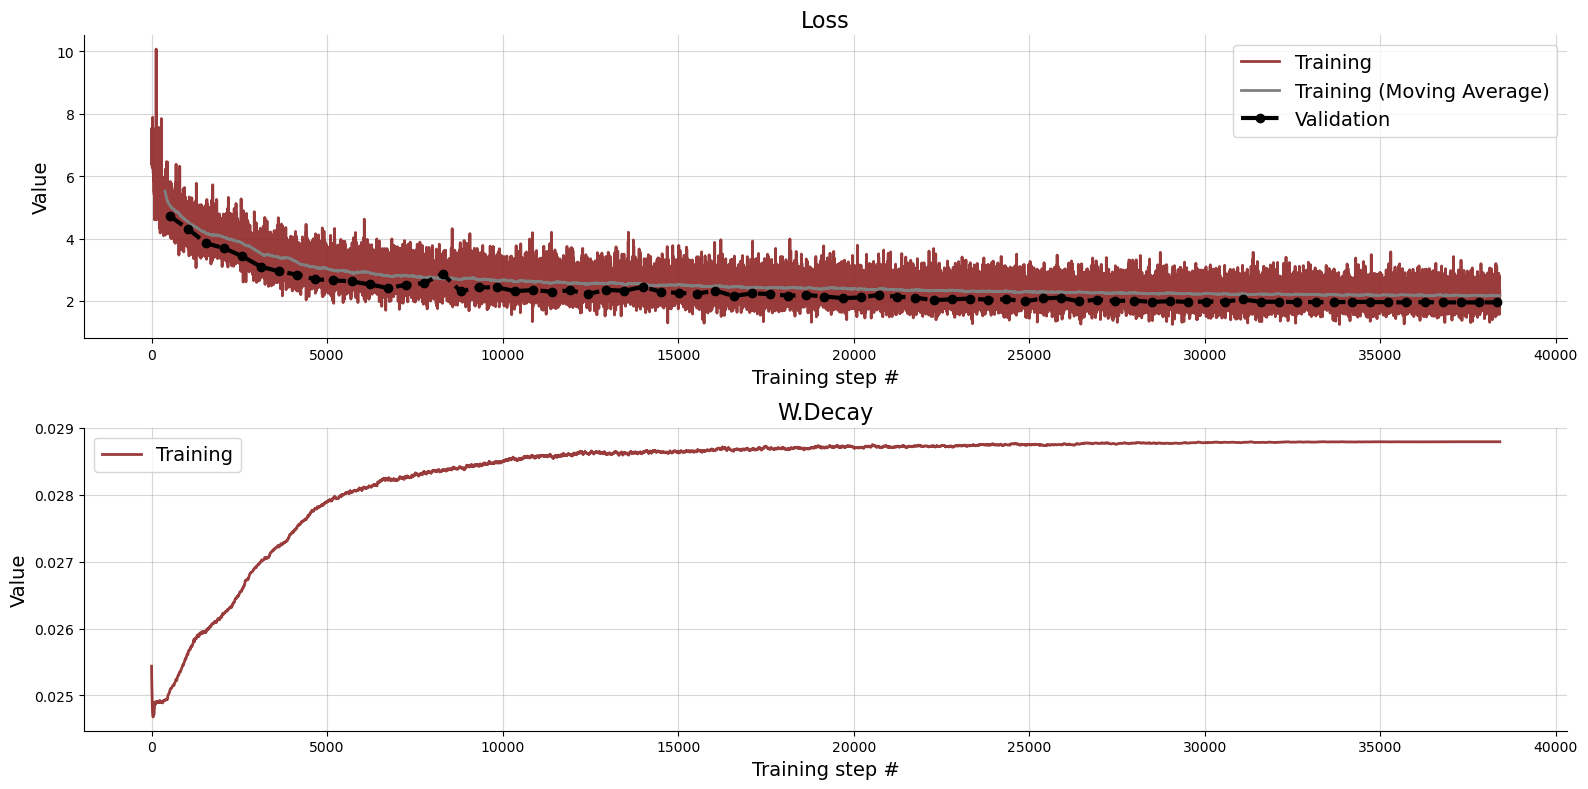

In [17]:
f = diag.plot_losses(h['train_losses'], h['val_losses'], moving_average=True)

In [18]:
# We can load the same data we use to test the network with prior context as our configurator ignores prior_batchable_context.
conf_10 = configure_input(pickle.load(open('simulations/sims_10.pkl', 'rb+')), prior_means, prior_stds, is_fix_alpha=True)

# Get posterior draws
draws_10 = amortizer.sample(conf_10, n_samples=250)

# Publication plots

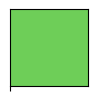

In [21]:
color_codes = {
    r"$\alpha = 1.0$": '#6ece58'
}
sns.palplot(color_codes.values())

In [23]:
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Palatino']

## SBC (Closed World)

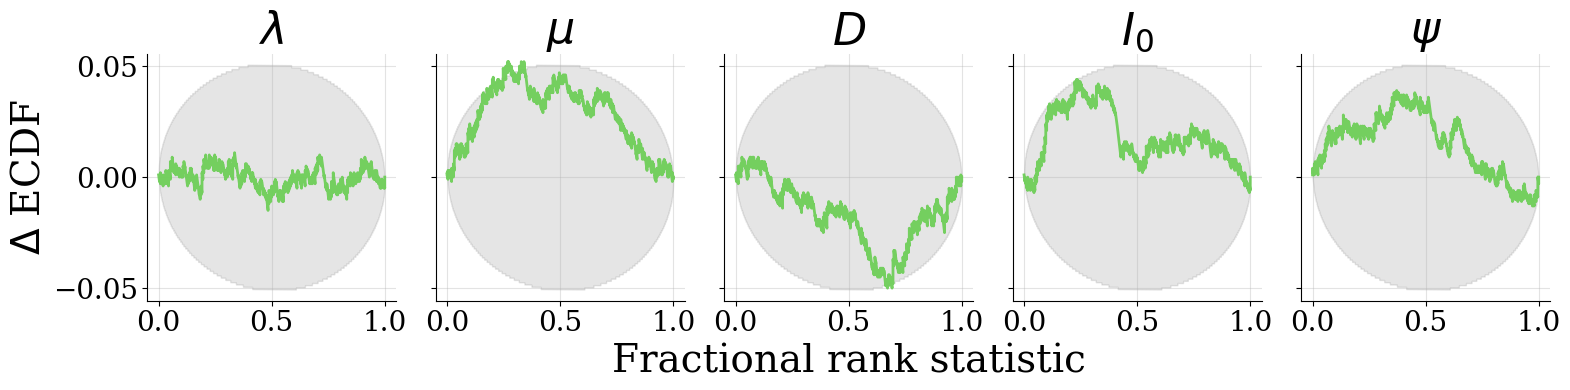

In [25]:
f, ax = plt.subplots(1, 5, figsize=(16, 4))
custom_plot_sbc_ecdf(draws_10, conf_10['parameters'], ax=ax, rank_ecdf_color=color_codes[r"$\alpha = 1.0$"], 
                     difference=True)

# Prettify plot
for i, _ax in enumerate(ax):
    sns.despine(ax=_ax)
    _ax.grid(alpha=0.35)
    _ax.set_title(param_names[i], fontsize=32)
    _ax.tick_params(axis="both", which="major", labelsize=20)
    _ax.tick_params(axis="both", which="minor", labelsize=20)
    _ax.set_xlabel("")
    _ax.set_xticks(np.linspace(0, 1, 3))
    if i > 0:
        _ax.set_ylim(ax[0].get_ylim())
        _ax.set_yticklabels([])

ax[2].set_xlabel("Fractional rank statistic", fontsize=28)
ax[0].set_ylabel(r'$\Delta$ ECDF', fontsize=28)
f.tight_layout()

In [26]:
f.savefig('../../figures/covid_ecdfs_unscaled.pdf', dpi=300, bbox_inches='tight')

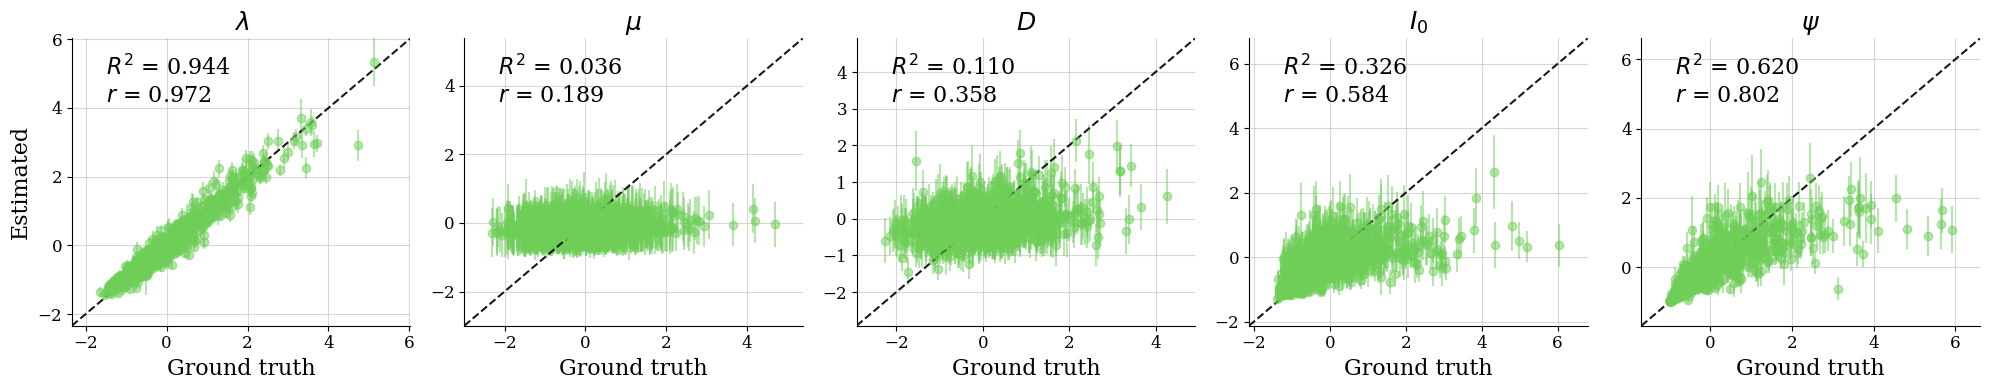

In [27]:
f = diag.plot_recovery(draws_10, conf_10["parameters"], param_names=param_names, color=color_codes[r"$\alpha = 1.0$"], )

In [28]:
f.savefig('../../figures/covid_recovery_unscaled.pdf', dpi=300, bbox_inches='tight')